In [2]:
import os
import cv2
import numpy as np
import pandas as pd

def generate_bounding_boxes(image_dir):
    image_files = os.listdir(image_dir)
    data = []

    for img_name in image_files:
        img_path = os.path.join(image_dir, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue

        img_resized = cv2.resize(img, (224, 224))
        gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            # Take the largest contour
            c = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(c)

            # Normalize the coordinates
            xmin = x / 224
            ymin = y / 224
            xmax = (x + w) / 224
            ymax = (y + h) / 224

            data.append((img_resized / 255.0, [xmin, ymin, xmax, ymax]))

    return zip(*data)

# Example
X_train_imgs, y_train_bboxes = generate_bounding_boxes("/content/drive/MyDrive/dataset/train")
X_test_imgs, y_test_bboxes = generate_bounding_boxes("/content/drive/MyDrive/dataset/test")

X_train = np.array(list(X_train_imgs))
y_train = np.array(list(y_train_bboxes))
X_test = np.array(list(X_test_imgs))
y_test = np.array(list(y_test_bboxes))


In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input

input_layer = Input(shape=(224, 224, 3))

x = Conv2D(32, (3,3), activation='relu')(input_layer)
x = MaxPooling2D(2,2)(x)
x = Conv2D(64, (3,3), activation='relu')(x)
x = MaxPooling2D(2,2)(x)
x = Conv2D(128, (3,3), activation='relu')(x)
x = MaxPooling2D(2,2)(x)
x = Flatten()(x)

x = Dense(128, activation='relu')(x)
output_layer = Dense(4, activation='sigmoid')(x)  # [xmin, ymin, xmax, ymax]

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=16)


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - loss: 0.0247 - mae: 0.0970 - val_loss: 0.0252 - val_mae: 0.1030
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - loss: 0.0273 - mae: 0.1003 - val_loss: 0.0252 - val_mae: 0.1030
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - loss: 0.0214 - mae: 0.0910 - val_loss: 0.0252 - val_mae: 0.1030
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - loss: 0.0260 - mae: 0.0981 - val_loss: 0.0252 - val_mae: 0.1030
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - loss: 0.0296 - mae: 0.1039 - val_loss: 0.0252 - val_mae: 0.1030
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - loss: 0.0231 - mae: 0.0927 - val_loss: 0.0252 - val_mae: 0.1030
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - loss: 0.0259 - mae: 0.0989 - val_loss: 0.0252 - val_mae: 0.1030
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - loss: 0.0266 - mae: 0.1000 - val_loss: 0.0252 - val_mae: 0.1030
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - loss: 0.0227 - mae: 

In [6]:
# Evaluate with IoU and MAE
def calculate_iou(box1, box2):
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])

    inter_area = max(0, xB - xA) * max(0, yB - yA)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area

    return inter_area / union_area if union_area > 0 else 0

preds = model.predict(X_test)
ious = [calculate_iou(y_test[i], preds[i]) for i in range(len(preds))]
print(f"Average IoU: {np.mean(ious):.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step
Average IoU: 0.6533


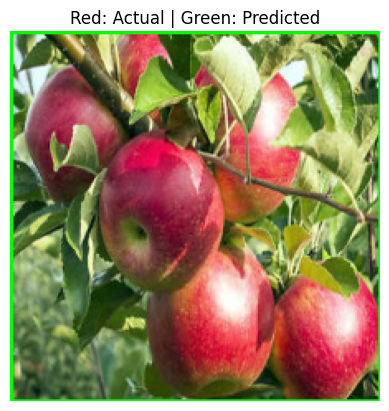

In [7]:
# Visualize Bounding Boxes
import matplotlib.pyplot as plt

def draw_bbox(img, bbox, color=(0, 255, 0), label=""):
    h, w = img.shape[:2]
    x1 = int(bbox[0] * w)
    y1 = int(bbox[1] * h)
    x2 = int(bbox[2] * w)
    y2 = int(bbox[3] * h)
    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
    cv2.putText(img, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    return img

# Visualize sample prediction
i = 0
img = (X_test[i] * 255).astype(np.uint8)
true_bbox = y_test[i]
pred_bbox = preds[i]

img_pred = draw_bbox(img.copy(), true_bbox, color=(255,0,0), label="Actual")
img_pred = draw_bbox(img_pred, pred_bbox, color=(0,255,0), label="Predicted")

plt.imshow(cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Red: Actual | Green: Predicted")
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step


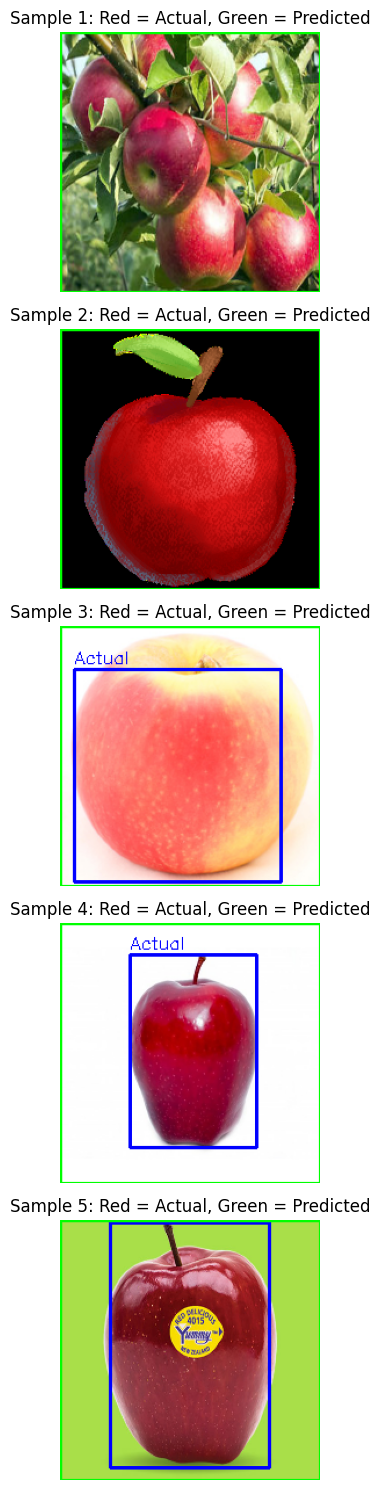

In [8]:
def visualize_predictions(X, y_true, y_pred, n=5):
    plt.figure(figsize=(15, n * 3))
    for i in range(n):
        img = (X[i] * 255).astype(np.uint8)
        true_bbox = y_true[i]
        pred_bbox = y_pred[i]

        img_out = draw_bbox(img.copy(), true_bbox, color=(255, 0, 0), label="Actual")
        img_out = draw_bbox(img_out, pred_bbox, color=(0, 255, 0), label="Predicted")

        plt.subplot(n, 1, i + 1)
        plt.imshow(cv2.cvtColor(img_out, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f"Sample {i+1}: Red = Actual, Green = Predicted")

    plt.tight_layout()
    plt.show()

# Generate predictions
predictions = model.predict(X_test)

# Visualize first 5 images
visualize_predictions(X_test, y_test, predictions, n=5)